In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [45]:
#Import Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Data Exploration 

In [46]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


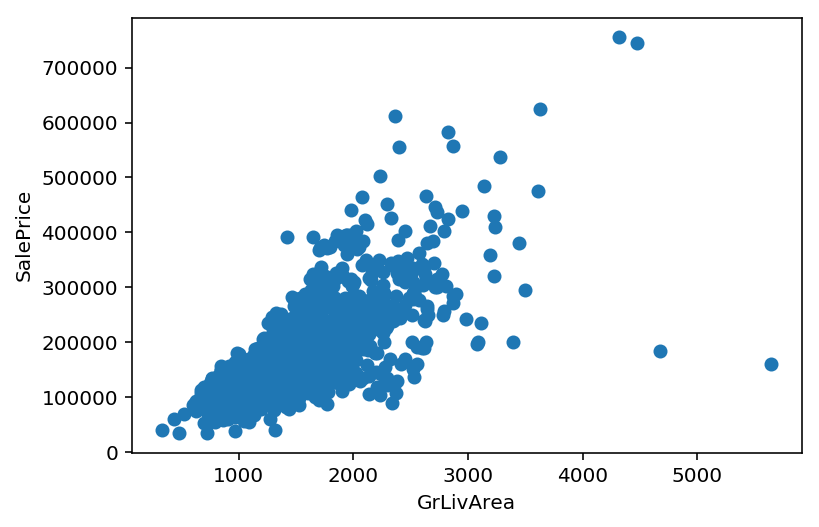

In [47]:
#Checking of outliers
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

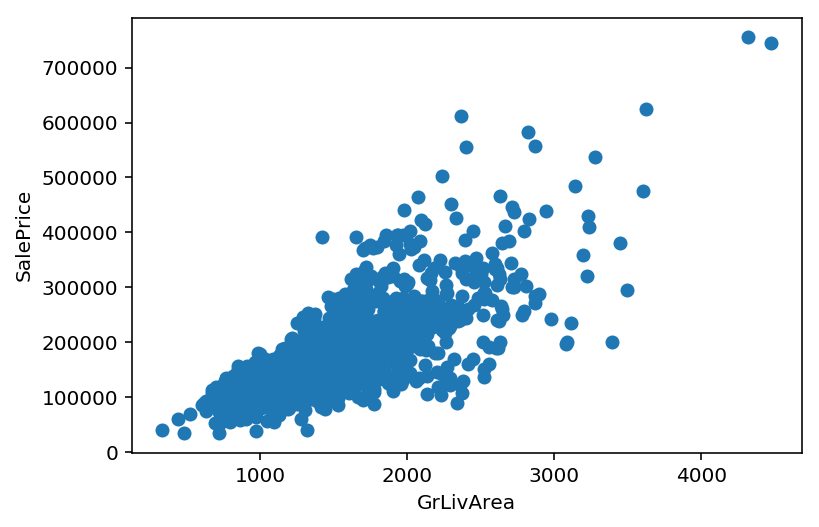

In [48]:
#Removal of outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11798c390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118e65e10>]], dtype=object)

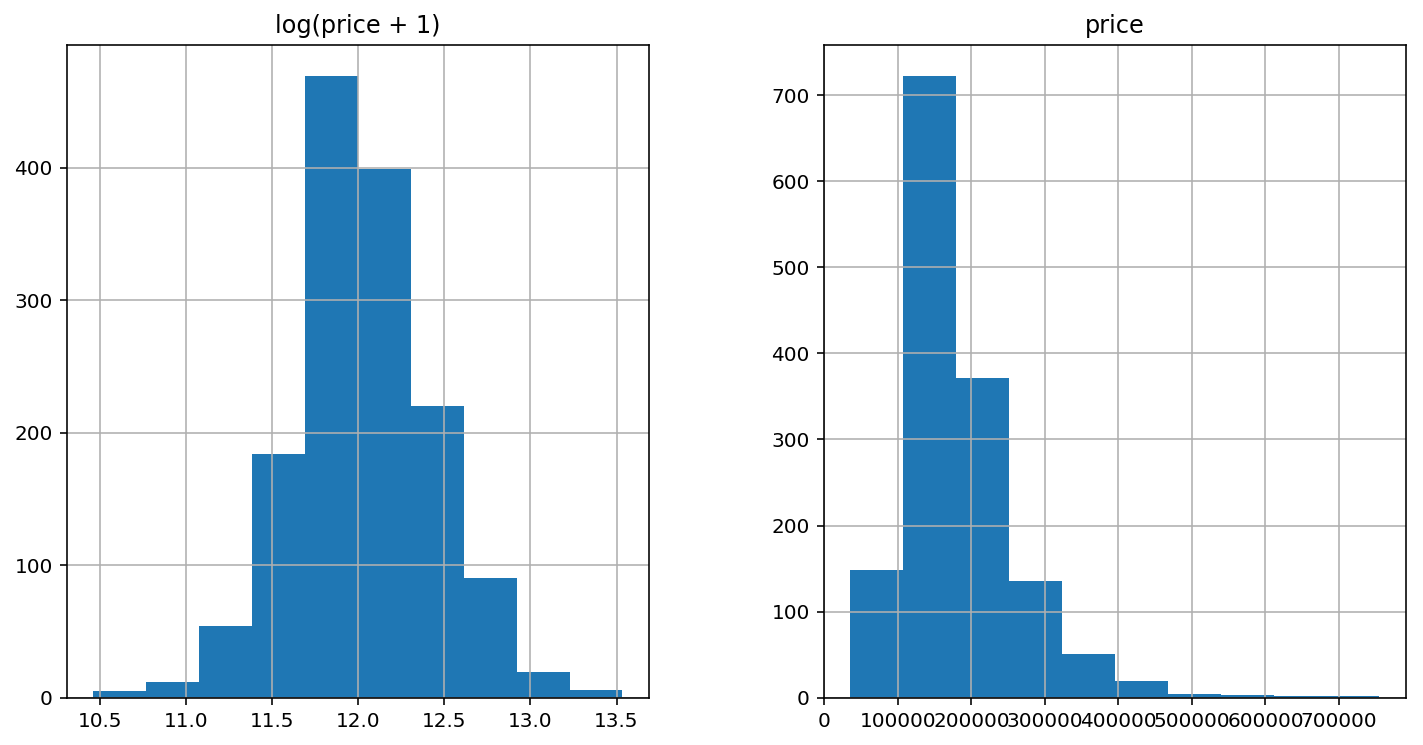

In [49]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [50]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [51]:
#Getting the Shape
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Shape of training dataset:", train.shape)
print("Shape of test dataset:", test.shape)
print("Number of Features:", train.shape[1])
print("Number of Numberical features:", train.select_dtypes(include=[np.number]).columns.shape[0])
print("Number of Categorical features:", train.select_dtypes(include=['object']).columns.shape[0])
print("Shape of all data:", all_data.shape)

Shape of training dataset: (1458, 81)
Shape of test dataset: (1459, 80)
Number of Features: 81
Number of Numberical features: 38
Number of Categorical features: 43
Shape of all data: (2917, 80)


In [52]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### Finding Missing Data and Imputing Values

In [53]:
#Now we have to check missing values in respective columns
#For that we define a function which can be used several times to recheck missing values later in the process
def total_missing():
    list_missing = all_data.columns[all_data.isnull().any()].tolist()
    return list_missing
all_data[total_missing()].isnull().sum().sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

In [54]:
#Maximum number of missig data are in PoolQC
#We fill the missing values with none since majority of houses have missing data and can assume there is no pool
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [55]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [56]:
all_data['Alley'] = all_data['Alley'].fillna('None')

In [57]:
all_data['Fence'] = all_data['Fence'].fillna('None')

In [58]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [59]:
#LotFrontage is missing for a number of values but LotArea is not missing. Since LotArea can be considered as area of a
#rectangle, we can take the square root of it to find the LotFrontage
#Check correlation with LotArea
all_data['LotFrontage'].corr(all_data['LotArea'])

0.76321838262368746

In [60]:
all_data['SqrtLotArea']=np.sqrt(all_data['LotArea'])
all_data['LotFrontage'].corr(all_data['SqrtLotArea'])

0.76884338596482971

In [61]:
#Correlation is better now. Lets move on with this
cond = all_data['LotFrontage'].isnull()
all_data.LotFrontage[cond]=all_data.SqrtLotArea[cond]

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
del all_data['SqrtLotArea']

In [63]:
#GarageType, GarageFinish, GarageQual and GarageCond, filling missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [64]:
#GarageYrBlt, GarageArea and GarageCars, filling missing data with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [65]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath, filling missing value with 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [66]:
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2, filling missing values with None
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [67]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [68]:
#MSZoning, filling missing value with the mode of the column
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [69]:
#Dropping Utilities
all_data = all_data.drop(['Utilities'], axis=1)

In [70]:
#Functional, filling missing values with Typ according to data description
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [71]:
#Electrical, filling missing values with the most common value
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [72]:
#KitchenQual, filling missing values with the most common value
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [73]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [74]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [75]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [76]:
#Check again for missing values
all_data[total_missing()].isnull().sum()

Series([], dtype: float64)

In [77]:
all_data = pd.get_dummies(all_data)

In [78]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.000000,5.017280,0.000000,...,0,0,0,0,0,0,0,1,0,1
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,0.693147,5.652489,0.000000,...,0,0,0,0,0,0,0,1,0,1
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.000000,6.075346,0.000000,...,0,0,0,0,0,0,0,1,0,1
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.000000,6.293419,5.609472,...,0,0,0,0,0,0,0,1,0,1
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.000000,6.196444,0.000000,...,0,0,0,0,0,0,0,1,0,1


In [79]:
#Creating matrices for model fitting
train = all_data[:ntrain]
test = all_data[ntrain:]

### Models

In [93]:
from sklearn.linear_model import LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost.sklearn import XGBRegressor

In [86]:
lcv = make_pipeline(RobustScaler(), LassoCV(cv=5, n_jobs=-1))
cv_lasso = cross_val_score(lcv, train, y_train, cv=5, n_jobs=-1)
print("CV score is:", np.mean(cv_lasso))

CV score is: 0.917787434079


In [88]:
rfr = make_pipeline(RobustScaler(), RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, random_state=1234))
cv_rfr = cross_val_score(rfr, train, y_train, cv=5, n_jobs=-1)
print("CV score is:", np.mean(cv_rfr))

CV score is: 0.888691914945


In [89]:
xgb = make_pipeline(RobustScaler(), XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4))
cv_xgb = cross_val_score(xgb, train, y_train, cv=5, n_jobs=-1)
print("CV score is:", np.mean(cv_xgb))

CV score is: 0.917105969981


In [91]:
enet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=0.9, n_alphas=100, random_state=3))
cv_enet = cross_val_score(enet, train, y_train, cv=5, n_jobs=-1)
print("CV score is:", np.mean(cv_enet))

CV score is: 0.917712425595


In [102]:
krr = make_pipeline(RobustScaler(), KernelRidge(alpha=0.2, kernel="polynomial", degree=2, coef0=2.5))
cv_krr = cross_val_score(krr, train, y_train, cv=5, n_jobs=-1)
print("CV score is:", np.mean(cv_krr))

CV score is: 0.920018121936


In [103]:
krr.fit(train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('kernelridge', KernelRidge(alpha=0.2, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None))])

In [107]:
y_pred = krr.predict(test)

In [109]:
np.expm1(y_pred)

array([ 119866.38050263,  158440.56710594,  185860.10598169, ...,
        168925.78489258,   97760.65920926,  220480.88167087])

In [113]:
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission['SalePrice'] = np.expm1(y_pred)
submission.to_csv('submission.csv', index=False)